# Problema do Caminho Mı́nimo (PCM)

O **Problema do Caminho Mínimo (PCM)** é um problema clássico da **Teoria dos Grafos** e da **Pesquisa Operacional**, cujo objetivo é encontrar o caminho de menor custo entre dois nós de um grafo. Esse problema tem diversas aplicações em logística, redes de telecomunicações, sistemas de transporte e até em inteligência artificial.

In [8]:
import cplex
import networkx as nx
import matplotlib.pyplot as plt
import string

## Leitura e pré-processamento de dados

Dado um **grafo dirigido ou não dirigido** $G = (V, E)$, onde:  
- $V$ é o conjunto de **nós (vértices)**.  
- $E$ é o conjunto de **arestas**, onde cada aresta $(i, j)$ possui um **peso $w_{ij}$** que representa o custo, tempo ou distância para ir do nó $i$ ao nó $j$.

In [9]:
file = "in_pcm.txt"

with open(file, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = list(filter(None, lines))

num_nodes, num_edges = map(int, lines[0].strip().split())
s, d = map(int, lines[1].strip().split())
letras = string.ascii_uppercase  # 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

arcs = {}
for line in lines[2:]:
    node1, node2, cost = map(int, line.strip().split())
    arcs[(node1, node2)] = cost

arcs

{(0, 1): 10,
 (0, 2): 16,
 (1, 4): 7,
 (1, 3): 11,
 (1, 2): 5,
 (2, 3): 3,
 (2, 5): 5,
 (3, 4): 6,
 (3, 6): 4,
 (3, 5): 5,
 (4, 6): 8,
 (5, 6): 7}

## Visualização do problema

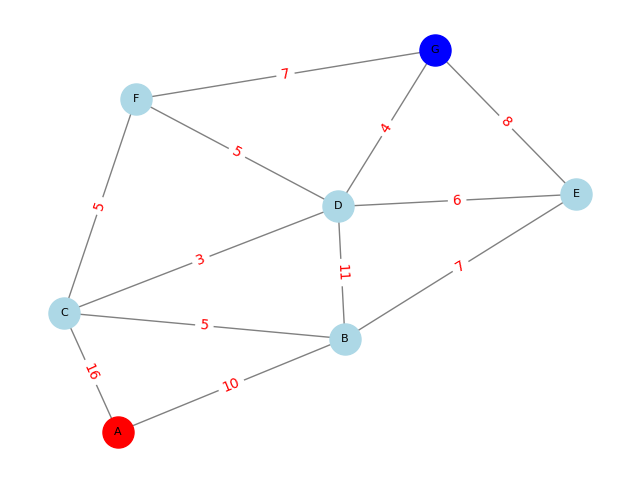

In [10]:
G = nx.Graph()

G.add_nodes_from(range(num_nodes))

for (u, v), cost in arcs.items():
    G.add_edge(u, v, weight=cost)

pos = nx.spring_layout(G, seed=42)

path_nodes = [node for node in G.nodes() if node not in [s, d]]
node_labels = {i: f'{letras[i]}' for i in G.nodes}
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, nodelist=[s], node_color='red', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[d], node_color='blue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.axis('off')
plt.show()

## Modelagem e solução

O objetivo é encontrar um caminho de custo mínimo entre um **nó de origem $s$** e um **nó de destino $d$**, minimizando a soma dos pesos das arestas percorridas:  

$\min \sum_{(i,j) \in P} w_{ij}$

onde $P$ é o conjunto de arestas pertencentes ao caminho escolhido.

In [11]:
model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)
model.objective.set_sense(model.objective.sense.minimize)

# Definir o vetor b para o balanço de fluxo:
# b[s] = 1, b[d] = -1 e 0 para os demais nós.
b = [0] * num_nodes
b[s] = 1
b[d] = -1

variaveis = []
obj = []
lb = []
ub = []

for (i, j), cost in arcs.items():
    var_name = f"x{letras[i]}{letras[j]}"
    variaveis.append(var_name)
    obj.append(cost)
    lb.append(0.0)
    ub.append(cplex.infinity)  # limite superior infinito

model.variables.add(names=variaveis, obj=obj, lb=lb, ub=ub)

# Adicionar restrições de balanço de fluxo para cada nó:
for i in range(num_nodes):
    indices = []
    coefs = []
    # Fluxo de saída: para todos os arcos com origem i
    for (u, v) in arcs.keys():
        if u == i:
            indices.append(f"x{letras[u]}{letras[v]}")
            coefs.append(1.0)
    # Fluxo de entrada: para todos os arcos com destino i
    for (u, v) in arcs.keys():
        if v == i:
            indices.append(f"x{letras[u]}{letras[v]}")
            coefs.append(-1.0)
    # Adiciona a restrição para o nó i
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=indices, val=coefs)],
        senses=["E"],
        rhs=[b[i]],
        names=[f"node_{letras[i]}"]
    )

%time model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 1 rows and 3 columns.
Aggregator did 3 substitutions.
Reduced LP has 3 rows, 6 columns, and 9 nonzeros.
Presolve time = 0.01 sec. (0.01 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =            19.000000
CPU times: user 20.5 ms, sys: 3.28 ms, total: 23.8 ms
Wall time: 23.3 ms


## Sumário dos resultados

In [12]:
print("Status da solução:", model.solution.get_status_string())
print(f"Custo total: {model.solution.get_objective_value()}")

solution = model.solution.get_values()
flow = {}
for idx, var in enumerate(variaveis):
    val = solution[idx]
    if val > 1e-6:
        parts = list(var)
        i = parts[1]
        j = parts[2]
        flow[(i, j)] = val

print("Fluxos (variáveis com valor > 0):")
for (i, j), val in flow.items():
    print(f"x{i}{j} = {val}")

model.write("./output/model_pcm.lp")
model.solution.write("./output/solution_pcm.sol")

# Reconstruindo o caminho mínimo
caminho = [letras[s]]
atual = letras[s]
while atual != letras[d]:
    for (u, v), val in flow.items():
        if u == atual and val > 0:
            caminho.append(v)
            atual = v
            break
    else:
        print("Caminho incompleto")
        break
print("Caminho:", caminho)

Status da solução: optimal
Custo total: 22.0
Fluxos (variáveis com valor > 0):
xAB = 1.0
xBC = 1.0
xCD = 1.0
xDG = 1.0
Caminho: ['A', 'B', 'C', 'D', 'G']


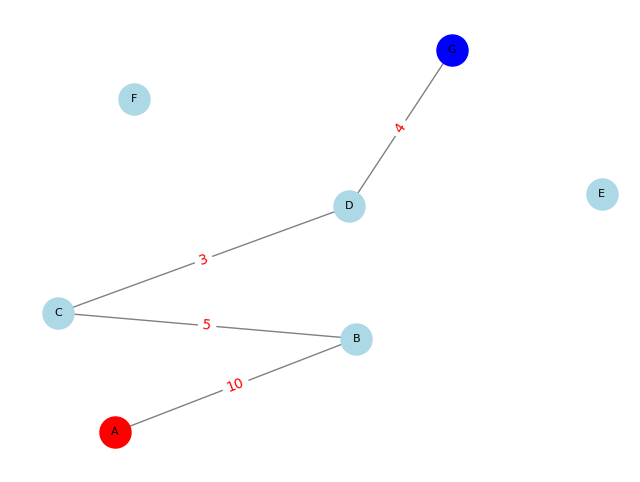

In [13]:
G = nx.Graph()

G.add_nodes_from(range(num_nodes))

for (u, v), val in flow.items():
    u = ord(u) - ord('A')
    v = ord(v) - ord('A')
    weight = arcs[(u, v)]
    G.add_edge(u, v, weight=weight)

edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, nodelist=[s], node_color='red', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=[d], node_color='blue', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='lightblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.axis('off')
plt.show()